# ⚛️ H₂ Ground-State VQE (Noisy Simulation)
## Classical Optimizer Comparison + Noisy Density-Matrix Analysis

This notebook explores the **Variational Quantum Eigensolver (VQE)** applied to
the hydrogen molecule **H₂**, simulated on a **noisy quantum device**.  

The goal is to understand:

- How different **classical optimizers** behave under noise  
- How noise affects **convergence** and **state populations**  
- How to reconstruct and analyse the **final noisy density matrix**  

The notebook uses your production-ready packages:

- `vqe.core.run_vqe_optimizer_comparison`  
- `vqe.core.run_vqe`  
- `vqe_qpe_common.plotting`  

which automatically handle:

- Caching  
- Noise injection  
- Device creation  
- Reproducibility  
- Figure saving  

---

## 🧪 Noise Model (NISQ-inspired)

For each qubit:

- **Depolarizing noise:** 10%  
- **Amplitude damping:** 10%  

These values intentionally exaggerate realistic NISQ noise so that behaviour
differences between optimizers become clearly visible.


In [1]:
# Core scientific stack
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

# VQE engine + plotting utilities
from vqe.core import run_vqe_optimizer_comparison, run_vqe
from vqe_qpe_common.plotting import IMG_DIR

# Molecular system
symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.7414]
])
basis = "sto-3g"

# Noise parameters
depolarizing_prob = 0.1
amplitude_damping_prob = 0.1

seed = 0

# 🔧 Part 1 — Noisy Optimizer Comparison

We compare three optimizers under identical noise conditions:

- `GradientDescent`  
- `Adam`  
- `Momentum`  

Using:

```python
run_vqe_optimizer_comparison(...)
```

This function:

✔ Creates the noisy device  
✔ Applies depolarizing + amplitude-damping channels  
✔ Runs each optimizer  
✔ Handles caching  
✔ Generates and saves a convergence plot  
✔ Displays the figure  

The returned object reports the **final energies** for each optimizer.


⚙️ Running optimizer: GradientDescent

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__TwoQubit-RY-CNOT__GradientDescent__VQE__noisy__s0__b997d6e2d647.json

⚙️ Running optimizer: Adam

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__TwoQubit-RY-CNOT__Adam__VQE__noisy__s0__f4f630400a62.json

⚙️ Running optimizer: Momentum

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__TwoQubit-RY-CNOT__Momentum__VQE__noisy__s0__89bf390c7aab.json


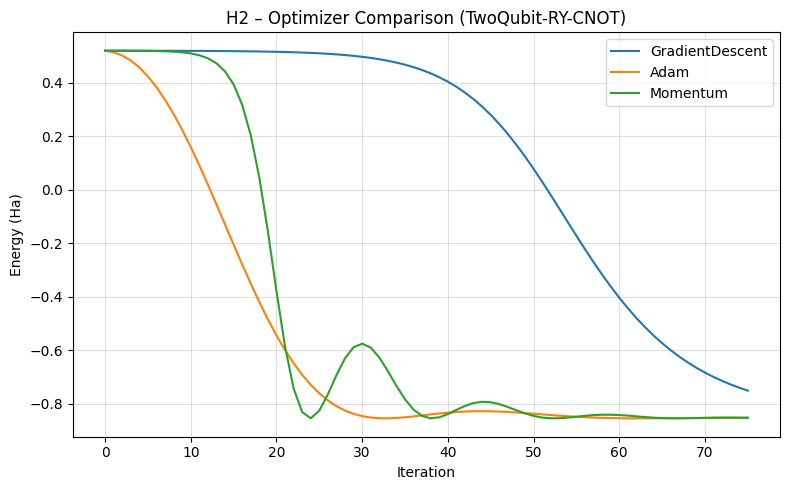

<Figure size 640x480 with 0 Axes>

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/H2_optimizer_comparison_ansTwoQubit-RY-CNOT.png


{'energies': {'GradientDescent': [0.5193932132173197,
   0.5193673690829155,
   0.5193367117052435,
   0.519300344989668,
   0.5192572061519682,
   0.5192060347532973,
   0.5191453360414388,
   0.5190733375068679,
   0.5189879373787164,
   0.5188866436934346,
   0.5187665021993211,
   0.5186240110165714,
   0.5184550196467284,
   0.5182546097836713,
   0.5180169544012325,
   0.5177351515761475,
   0.5174010285718417,
   0.517004911052536,
   0.516535351898669,
   0.5159788129548443,
   0.515319292057149,
   0.5145378875501192,
   0.5136122908303985,
   0.512516197380557,
   0.5112186264627857,
   0.5096831391729296,
   0.5078669455200913,
   0.505719893792442,
   0.5031833377298978,
   0.5001888837704496,
   0.4966570288342159,
   0.49249571269657255,
   0.4875988264222117,
   0.4818447445742047,
   0.47509498136600165,
   0.4671931134708988,
   0.45796416465219225,
   0.4472147068755003,
   0.43473399463088813,
   0.42029651255788786,
   0.4036663542881518,
   0.38460385549944853,
   

In [2]:
optimizers = ["GradientDescent", "Adam", "Momentum"]

comparison = run_vqe_optimizer_comparison(
    molecule="H2",
    ansatz_name="TwoQubit-RY-CNOT",
    optimizers=optimizers,
    steps=75,
    stepsize=0.1,
    noisy=True,
    depolarizing_prob=depolarizing_prob,
    amplitude_damping_prob=amplitude_damping_prob,
    force=False,
    show=True
)

comparison

# ⭐ Part 2 — Identify the Worst Optimizer

Because noise degrades the optimization landscape, different optimizers
converge to different energies.

We now select the **worst-performing optimizer**, defined as the one with the
**highest final energy**.

In [3]:
worst_optimizer = max(
    comparison["final_energies"],
    key=comparison["final_energies"].get
)

print(f"🏆 Worst optimizer under noise: {worst_optimizer}")

🏆 Worst optimizer under noise: GradientDescent


# 🔍 Part 3 — Full Noisy VQE Using the Worst Optimizer

We now run a complete noisy VQE workflow with:

- **Ansatz:** `TwoQubit-RY-CNOT`  
- **Optimizer:** worst performer  
- **Noise:** 10% depolarizing + 10% amplitude damping  
- **Steps:** 75  

The call below returns:

- `final_state_real` / `final_state_imag` (density matrix)  
- `energies`  
- full configuration & metadata  

We reconstruct the density matrix and analyse its diagonal populations.

In [4]:
res = run_vqe(
    molecule="H2",
    ansatz_name="TwoQubit-RY-CNOT",
    optimizer_name=worst_optimizer,
    n_steps=75,
    stepsize=0.1,
    noisy=True,
    depolarizing_prob=depolarizing_prob,
    amplitude_damping_prob=amplitude_damping_prob,
    plot=False,
    seed=0,
    force=False
)

rho = np.array(res["final_state_real"]) + 1j * np.array(res["final_state_imag"])
diag_elements = np.diag(rho)
diag_elements


📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__TwoQubit-RY-CNOT__GradientDescent__VQE__noisy__s0__b997d6e2d647.json


tensor([5.10152463e-02+0.j, 3.25629232e-03+0.j, 3.25629232e-03+0.j,
        2.07848446e-04+0.j, 1.61298370e-01+0.j, 1.02956406e-02+0.j,
        1.02956406e-02+0.j, 6.57168551e-04+0.j, 1.61298370e-01+0.j,
        1.02956406e-02+0.j, 1.02956406e-02+0.j, 6.57168551e-04+0.j,
        5.09988014e-01+0.j, 3.25524264e-02+0.j, 3.25524264e-02+0.j,
        2.07781445e-03+0.j], requires_grad=True)

# 🧮 Part 4 — Ket-Form Approximation from the Noisy Density Matrix

For mixed states, the diagonal entries of ρ correspond to **basis-state
populations** after noise.

We extract terms above a threshold and build a compact approximate ket
representation:


In [5]:
threshold = 1e-2
num_wires = int(np.log2(len(diag_elements)))

ket_terms = []
for idx, amp in enumerate(diag_elements):
    if abs(amp) > threshold:
        ket_terms.append(f"({amp:.4f}|{idx:0{num_wires}b}⟩)")

ket_notation = " + ".join(ket_terms)

print("Approximate noisy state:")
print(f"|ψ⟩ ≈ {ket_notation}")

Approximate noisy state:
|ψ⟩ ≈ (0.0510+0.0000j|0000⟩) + (0.1613+0.0000j|0100⟩) + (0.0103+0.0000j|0101⟩) + (0.0103+0.0000j|0110⟩) + (0.1613+0.0000j|1000⟩) + (0.0103+0.0000j|1001⟩) + (0.0103+0.0000j|1010⟩) + (0.5100+0.0000j|1100⟩) + (0.0326+0.0000j|1101⟩) + (0.0326+0.0000j|1110⟩)


# 📊 Part 5 — Basis-State Population Plot

A bar plot of the **diagonal entries of ρ** shows which computational basis
states survive under noise.

- Blue bars = real population  
- Orange bars = imaginary component  

Imaginary parts are typically very small but are included for completeness.

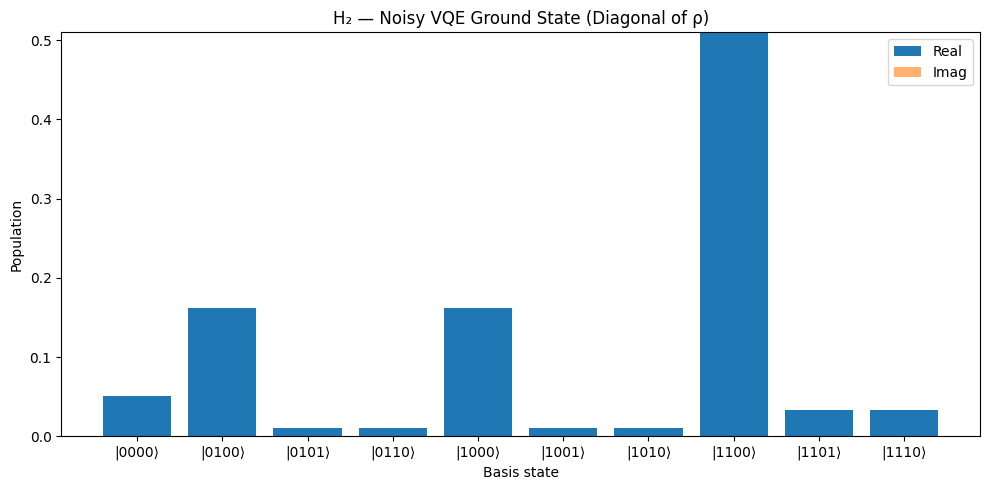

In [6]:
indices = np.where(abs(diag_elements) > threshold)[0]
values = diag_elements[indices]
labels = [f"|{i:0{num_wires}b}⟩" for i in indices]

plt.figure(figsize=(10, 5))
plt.bar(labels, values.real, label="Real")
plt.bar(labels, values.imag, bottom=values.real, alpha=0.6, label="Imag")

plt.xlabel("Basis state")
plt.ylabel("Population")
plt.title("H₂ — Noisy VQE Ground State (Diagonal of ρ)")
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(IMG_DIR, "H2_Noisy_Ground_State.png"), dpi=300)
plt.show()